# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

In [2]:
import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/eCREST/eCREST')

In [3]:
# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [4]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [5]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [6]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [7]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [8]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [9]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [10]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


# Load files

## mg_network file names

In [40]:
dirpath = Path(settings_dict['save_dir'])


In [41]:
nodefiles = get_cell_filepaths(dirpath)

In [42]:
len(nodefiles)

5817

## df_syn pre or post

In [54]:
df_syn = pd.read_csv(dirpath / 'graphs/df_postsyn_mg.csv')
syn = 'post-synaptic'

In [55]:
len(df_syn)

8876

In [56]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

# cell types for all files in directory

## from file

In [57]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [19]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
['369219654']


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [20]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [21]:
df_type_auto.dropna(inplace=True)

In [22]:
df_type_auto.head()

,id,cell_type
104,127607174,mg2
106,127672247,mg2
155,129572524,mg1
753,213501262,mg1
778,214440956,mg2


## combine manual and auto df_type

In [23]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [24]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,107201352,mli
4,109348216,mli


### save to file

In [25]:
df_type.to_csv(dirpath / 'metadata/df_type.csv')

## cell type counts

In [18]:
df_type.groupby('cell_type').count()

,Unnamed: 0,id
cell_type,,
UK,1,1
aff,90,90
fov,1904,1904
glia,147,147
grc,753,753
h,97,97
lf,46,46
lg,42,42
mg1,81,81


# add cell type to df_syn

In [58]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [38]:
# include only connections from&to the following types/groups of cells
pre_groups = ['mg1','mg2']
post_groups = ['tsd']#,'sg1','sg2','smpl','grc','aff']
len(df_syn[(df_syn['post_type'].isin(post_groups)) & df_syn['pre_type'].isin(pre_groups)])
# len(df_syn)

304

In [32]:
df_syn.groupby(['post_type'])['post'].nunique()

post_type
fov     519
glia    102
grc      14
h        33
lf       46
lg       42
mg1      67
mg2      65
mli       1
sg1      44
sg2      38
sgx1      8
sgx2     13
smpl     13
tsd      57
uk      236
Name: post, dtype: int64

# shuffle df_syn

In [48]:
df_syn_rand = deepcopy(df_syn)

shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn = df_syn_rand

# --> df_edges

In [26]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf


In [19]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [43]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

In [44]:
mask = (df_edges['post'].isin([299496636])) & (df_edges['pre_type'].isin(['mg2']))
df_edges[mask]['pre'].values

array([387382792, 386392158, 472361842, 472517114, 472284925,  40665046,
       472051969, 558300217, 646634295, 129030308, 303166992, 300503092,
       300689181])

In [36]:
# import random 
from random import sample

randsubsamp = sample(list(df_edges[df_edges['pre_type'].isin(['mg1'])]['pre'].unique()),5) + sample(list(df_edges[df_edges['pre_type'].isin(['mg2'])]['pre'].unique()),5)

# randsubsamp = sample(list(df_edges['pre'].unique()),10)
df_edges = df_edges[df_edges['pre'].isin(randsubsamp)]

## distribution number of synapses per post cell

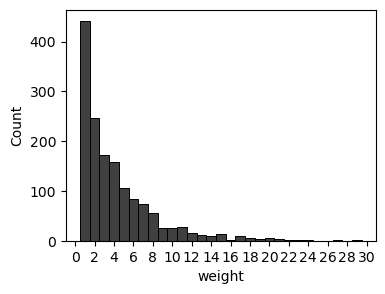

In [45]:
hfig,ax = plt.subplots(1,figsize=(4,3))
sns.histplot(data=df_edges[df_edges['post_type'].isin(['lg','lf','mg1','mg2'])],x='weight',color='black',ax=ax,bins=np.arange(0.5,30.5))
ax.set_xticks(np.arange(0,31,2));

# Color Palette

In [45]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'
}

# synapses locations in df_syn

## absolute

In [20]:
df_syn['depth'] = pd.cut(df_syn['y_adj'], bins=np.arange(-100,20,5))

In [21]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2,"(-55, -50]"
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2,"(-55, -50]"
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2,"(-55, -50]"
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf,"(-55, -50]"
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf,"(-60, -55]"


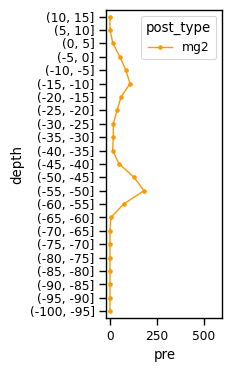

In [35]:
mask = df_syn['post_type'].isin(['mg2'])#,'mli','tsd','dml'])# df_edges['pre'].isin([295969348,295969442,295969134,295969355,295968777,282228761,283375247,283391297,283390956,282230475,268614458,268614383,273086215,187230424,290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) &  

df_grouped = df_syn[mask][['pre','post_type','depth']].groupby(['depth','post_type'],observed=False).count().reset_index()

df_grouped.loc[df_grouped['post_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['post_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['post_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['post_type'].isin(['mli','tsd','dml']),'class'] = 'smooth'

df_grouped['weight_norm'] = df_grouped.groupby('depth',observed=False)['pre'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth',observed=False)['pre'].transform(lambda x: (x.sum()) )


# Create a seaborn plot
sns.set_context('paper',font_scale=1)
hfig,ax = plt.subplots(1,figsize=(1.5,4))
sns.pointplot(data=df_grouped,y='depth', x='pre',hue = 'post_type',palette=syn_colors,linewidth=1)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
ax.set_xlim(-20,600)
plt.savefig('/Users/kperks/Downloads/MG2_synapse_locations_binned.svg',transparent=True) 

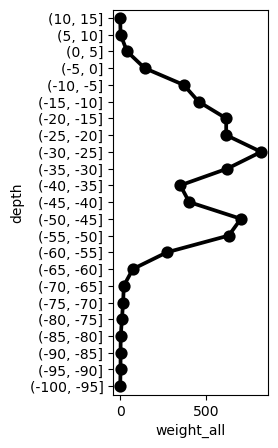

In [230]:
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_all',color='black')
ax.invert_yaxis()

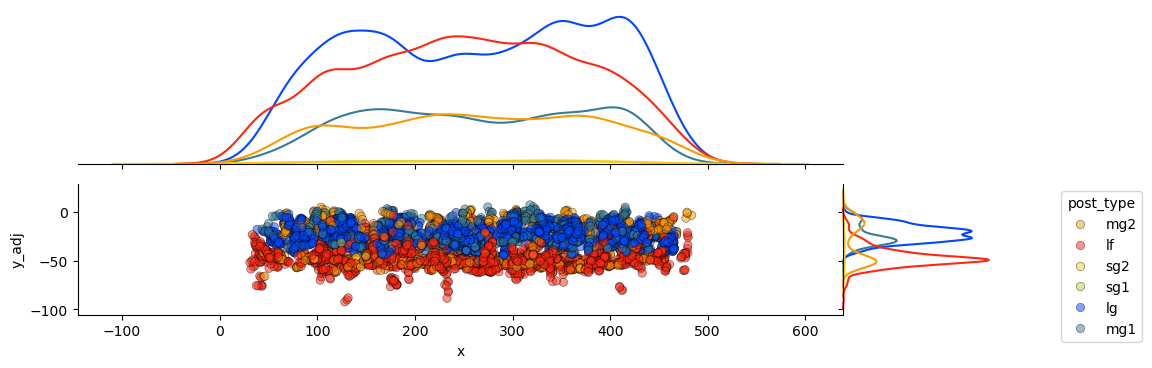

In [146]:

g = sns.jointplot(data=df_syn[df_syn['post_type'].isin(['mg2','mg1','sg2','sg1','lg','lf'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

## soma synapses

In [28]:
df_syn.head()
mask = df_syn['post_type'].isin(['mg1','mg2','lg']) & df_syn['structure'].isin(['unknown'])
df_syn[mask].head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
55,55,126618353,299404889,unknown,255.488,265.024,41.28,-11.342343,mg1,mg2
63,63,127607174,128770984,unknown,243.920,267.968,12.09,-15.912267,mg2,lg
64,64,127607174,128737253,unknown,228.528,268.192,22.59,-15.046832,mg2,mg1
65,65,127607174,128737253,unknown,225.520,270.416,23.25,-17.096085,mg2,mg1
66,66,127607174,129838223,unknown,214.032,273.808,23.13,-19.896548,mg2,lg


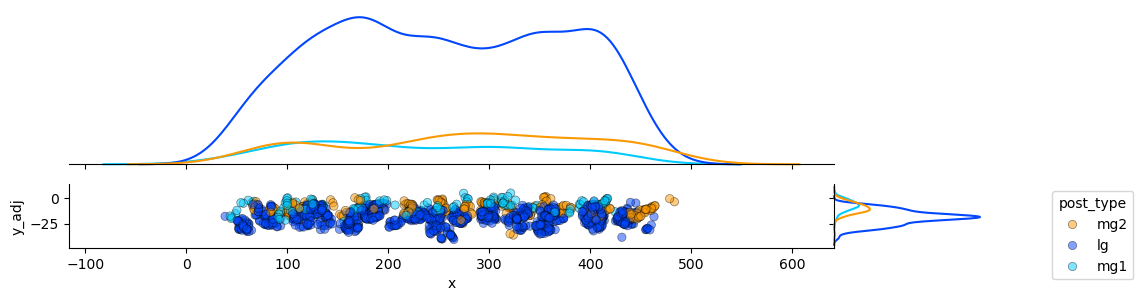

In [31]:
# sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue = 'post_type')
# # Set equal axes
# plt.axis('equal')
g = sns.jointplot(data=df_syn[mask], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="post_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

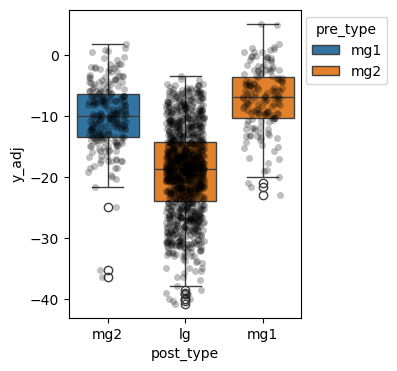

In [45]:
hfig,ax = plt.subplots(1,figsize=(3,4))
sns.stripplot(ax=ax,data=df_syn[mask], x='post_type', y='y_adj', color='black',alpha=0.25,jitter=0.25)# hue='pre_type')#,jitter=True)
sns.boxplot(ax=ax,data=df_syn[mask], x='post_type', y='y_adj', hue='pre_type')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.4, 1));

<AxesSubplot:xlabel='Density', ylabel='y_adj'>

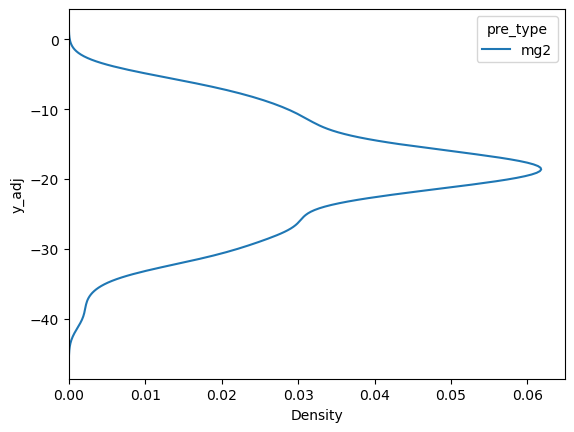

In [49]:
sns.kdeplot(data = df_syn[mask&(df_syn['post_type'].isin(['lg']))], y = 'y_adj',hue = 'pre_type')

<AxesSubplot:xlabel='Density', ylabel='y_adj'>

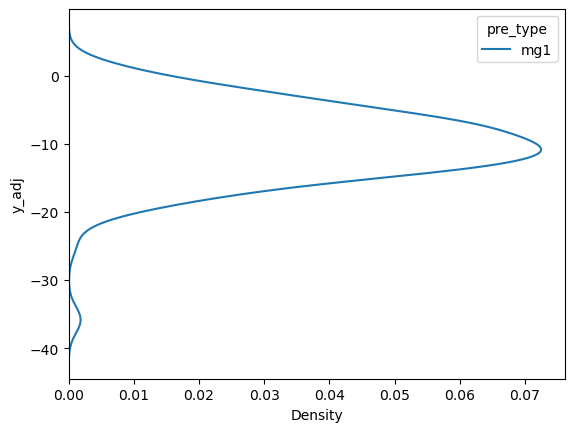

In [50]:
sns.kdeplot(data = df_syn[mask&(df_syn['post_type'].isin(['mg2']))], y = 'y_adj',hue = 'pre_type')

In [32]:
df_syn[mask].groupby(['post_type','pre_type']).count()

,,Unnamed: 0,pre,post,structure,x,y,z,y_adj
post_type,pre_type,,,,,,,,
lg,mg2,1075,1075,1075,1075,1075,1075,1075,1075
mg1,mg2,153,153,153,153,153,153,153,153
mg2,mg1,225,225,225,225,225,225,225,225


## structure specificity

#### how many synapses do MG tend to make or get onto each substructure?

In [64]:
mask = df_syn['post_type'].isin(['mg1','mg2'])
df_sum = df_syn[mask][['post','structure']].value_counts().reset_index(name='weight')
df_sum[['weight','structure']].groupby('structure').describe()

weight                                                 
                 count       mean       std  min  25%  50%    75%   max
structure                                                              
apical dendrite   25.0   1.960000  1.240967  1.0  1.0  2.0   2.00   6.0
axon              24.0   1.291667  0.550033  1.0  1.0  1.0   1.25   3.0
basal dendrite   119.0  10.512605  9.638258  1.0  3.0  7.0  16.50  43.0
multiple          11.0   3.181818  2.750207  1.0  1.0  2.0   5.00   9.0
unknown           74.0   5.216216  4.095672  1.0  2.0  4.0   6.75  19.0

In [67]:
#what about just for mg that get mg syn on 'unknown',axon, or apical dend?
focal_ids = df_sum[df_sum['structure'].isin(['unknown','axon','apical dendrite'])]['post'].unique()
mask = df_sum['post'].isin(focal_ids)
df_sum[mask][['weight','structure']].groupby('structure').describe()

weight                                                  
                 count       mean        std  min  25%  50%    75%   max
structure                                                               
apical dendrite   25.0   1.960000   1.240967  1.0  1.0  2.0   2.00   6.0
axon              24.0   1.291667   0.550033  1.0  1.0  1.0   1.25   3.0
basal dendrite    71.0  12.028169  10.001388  1.0  4.0  8.0  18.00  43.0
multiple          10.0   3.400000   2.796824  1.0  1.0  2.5   5.50   9.0
unknown           74.0   5.216216   4.095672  1.0  2.0  4.0   6.75  19.0

<AxesSubplot:xlabel='weight', ylabel='structure'>

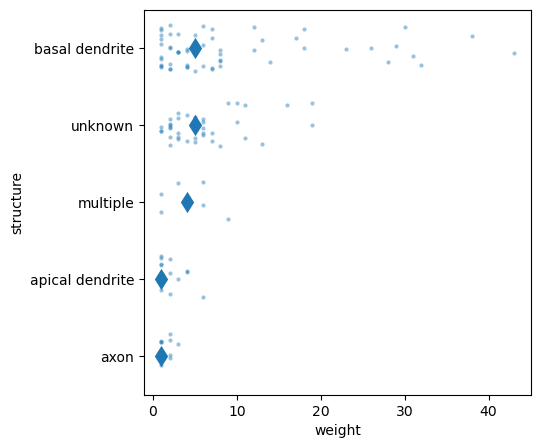

In [147]:
mask = df_syn['post_type'].isin(['mg2','mg1'])
df_sum = df_syn[mask][['post','structure']].value_counts().reset_index(name='weight')

hfig,ax = plt.subplots(1,figsize=(5,5))
sns.stripplot(ax=ax,
    data=df_sum, x="weight", y="structure",
    dodge=True, alpha=.45, zorder=1, legend=False,jitter=0.3, size=3#palette='dark'
)
sns.pointplot(ax=ax,
    data=df_sum, x="weight", y="structure",  errorbar=None,
    markers="d", markersize=8, linestyle="none", estimator='median'
) # dodge=.8 - .8 / df_sum['structure'].nunique(),

In [203]:
mask = df_syn['post_type'].isin(['mg1','mg2'])
df_sum = df_syn[mask][['pre','structure']].value_counts().reset_index(name='weight')
df_sum[['weight','structure']].groupby('structure').describe()

weight                                                  
                 count       mean        std  min  25%  50%    75%   max
structure                                                               
apical dendrite   22.0   2.227273   1.601541  1.0  1.0  2.0   2.00   8.0
axon              24.0   1.291667   0.550033  1.0  1.0  1.0   1.25   3.0
basal dendrite   114.0  10.973684  10.147985  1.0  3.0  7.5  16.00  43.0
multiple          16.0   2.187500   1.376893  1.0  1.0  2.0   3.00   5.0
unknown           71.0   5.436620   4.397182  1.0  2.0  4.0   7.00  22.0

<AxesSubplot:xlabel='weight', ylabel='structure'>

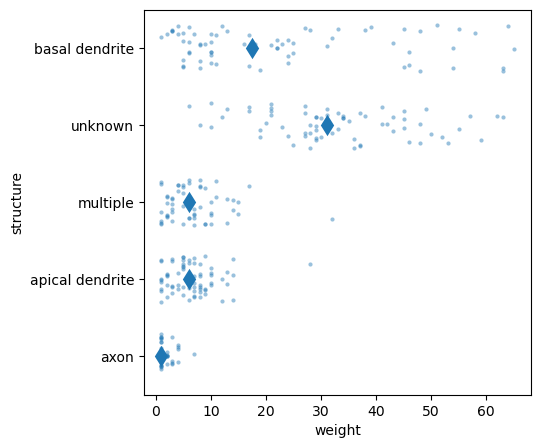

In [152]:
mask = df_syn['pre_type'].isin(['mg1','mg2'])
df_sum = df_syn[mask][['pre','structure']].value_counts().reset_index(name='weight')

hfig,ax = plt.subplots(1,figsize=(5,5))
sns.stripplot(ax=ax,
    data=df_sum, x="weight", y="structure",
    dodge=True, alpha=.45, zorder=1, legend=False,jitter=0.3, size=3#palette='dark'
)
sns.pointplot(ax=ax,
    data=df_sum, x="weight", y="structure",  errorbar=None,
    markers="d", markersize=8, linestyle="none", estimator='median'
) # dodge=.8 - .8 / df_sum['structure'].nunique(),

#### break the data down by morphology spectrum

In [111]:
morpho_savepath = Path(dirpath).parent / 'meta_analysis/morphology_cat/'

In [112]:
df_morpho_pca = pd.read_csv(morpho_savepath / 'df_morphology_cat_pca.csv')

In [113]:
df_morpho_pca.head()

,Unnamed: 0,index,id,cell_type,soma_diam,bd_std_x,ax_std_x,ax_std_z,bd_std_z,ad_count_y,0,1,2,3,4,5
0,0,0,126618353,mg1,10.77,26885.253906,45824.910156,11402.886719,26697.388672,117767.0,5.044233,0.784550,2.632025,-0.733256,0.457892,0.903150
1,1,1,127641472,sg1,6.71,5969.375977,6667.420898,7354.022949,5803.358887,4338.0,-1.465525,0.278558,-0.002606,-0.041103,-0.104724,0.075658
2,2,2,127838393,sg1,7.38,6605.987305,5829.034668,10449.576172,3608.284912,3809.0,-1.303950,0.092897,-0.304693,0.394465,-0.181403,-0.237371
3,3,3,127857293,sg1,7.03,3872.944336,6272.770508,9299.523438,4290.338867,6057.0,-1.487827,0.110392,-0.173662,0.328780,0.058707,0.015625
4,4,4,127870654,mg1,10.87,27302.193359,39620.093750,24061.080078,23264.437500,91307.0,5.003128,-0.530494,1.146281,-0.035243,-0.137361,0.566359


<AxesSubplot:xlabel='soma_diam', ylabel='0'>

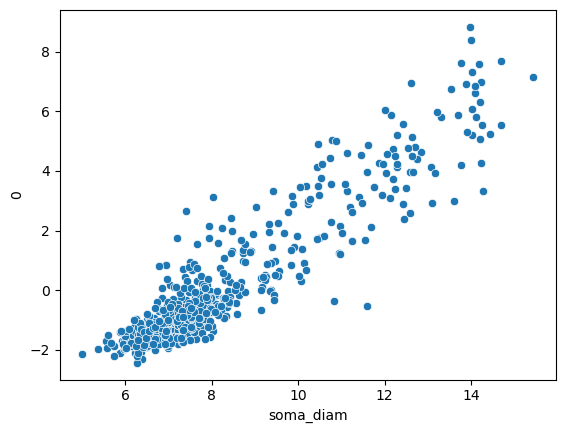

In [146]:
sns.scatterplot(data = df_morpho_pca,x = 'soma_diam',y = '0')

<AxesSubplot:xlabel='0'>

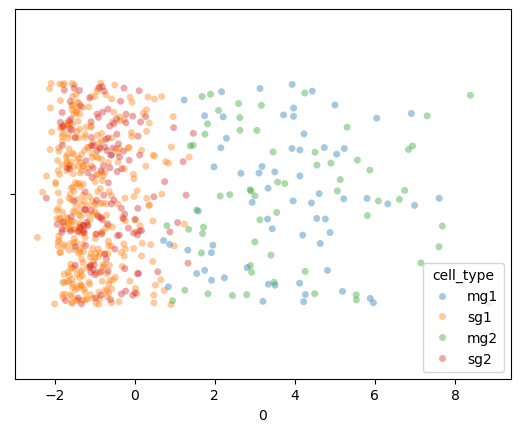

In [180]:
sns.stripplot(data=df_morpho_pca,x='0',hue='cell_type',jitter = 0.3,alpha = 0.4)

<AxesSubplot:xlabel='cell_type', ylabel='0'>

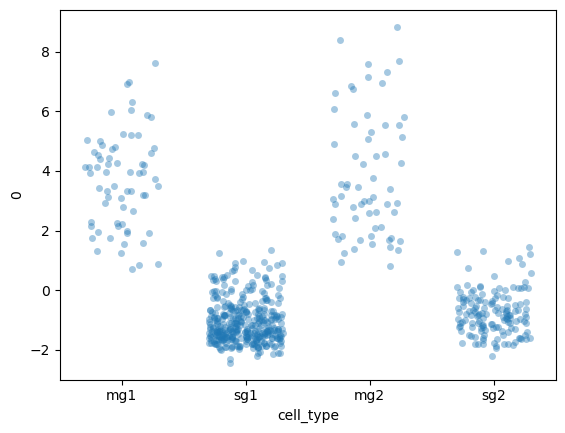

In [181]:
sns.stripplot(data=df_morpho_pca,x='cell_type',y='0',jitter = 0.3,alpha = 0.4)

#### for post mg cells, what is pc0 of their mg inputs onto substructures

In [298]:
mask = df_syn['post_type'].isin(['mg2','mg1'])
merge_on = 'pre'

df_morpho_pca[merge_on] = df_morpho_pca['id'].astype('int') #create a column to sync this data with 'pre' id in each column
merged_df = pd.merge(df_syn[mask], df_morpho_pca[[merge_on,'0']], on=merge_on) # merge df_syn with the pca results on pc0
merged_df.rename({'0':'pre_pc0'},axis=1,inplace=True)

# for each post cell and each sub-structure, what is the stats of the pre-mg pc0 value:
grouped_df = merged_df.groupby(['post','structure'])['pre_pc0'].describe().reset_index()
grouped_df.head()

,post,structure,count,mean,std,min,25%,50%,75%,max
0,40448913,basal dendrite,1.0,5.804540,NaN,5.804540,5.804540,5.804540,5.804540,5.804540
1,40508404,basal dendrite,27.0,3.378712,1.724363,1.694134,1.828479,3.052189,3.403637,7.305207
2,40665046,unknown,3.0,4.607159,0.000000,4.607159,4.607159,4.607159,4.607159,4.607159
3,41579854,basal dendrite,1.0,3.052189,NaN,3.052189,3.052189,3.052189,3.052189,3.052189
4,41579854,unknown,1.0,6.940574,NaN,6.940574,6.940574,6.940574,6.940574,6.940574


In [299]:
grouped_df['post'].nunique()

131

<AxesSubplot:xlabel='structure', ylabel='50%'>

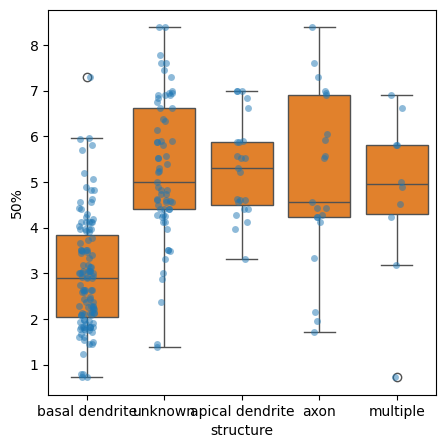

In [186]:
hfig,ax = plt.subplots(1,figsize=(5,5))
indep_var = '50%'
sns.stripplot(data = grouped_df,x = 'structure',y=indep_var,ax=ax,zorder=3,alpha=0.5)
sns.boxplot(data = grouped_df,x = 'structure',y=indep_var,ax=ax)

#### pairplot pc0 of inputs onto unknown vs basal dend for cells that have input to both 

In [300]:
mask = df_syn['post_type'].isin(['mg2','mg1'])
merge_on = 'pre'

df_morpho_pca[merge_on] = df_morpho_pca['id'].astype('int') #create a column to sync this data with 'pre' id in each column
merged_df = pd.merge(df_syn[mask], df_morpho_pca[[merge_on,'0']], on=merge_on) # merge df_syn with the pca results on pc0
merged_df.rename({'0':'pre_pc0'},axis=1,inplace=True)

# for each post cell and each sub-structure, what is the stats of the pre-mg pc0 value:
grouped_df = merged_df.groupby(['post','structure'])['pre_pc0'].describe().reset_index()
grouped_df.head()

,post,structure,count,mean,std,min,25%,50%,75%,max
0,40448913,basal dendrite,1.0,5.804540,NaN,5.804540,5.804540,5.804540,5.804540,5.804540
1,40508404,basal dendrite,27.0,3.378712,1.724363,1.694134,1.828479,3.052189,3.403637,7.305207
2,40665046,unknown,3.0,4.607159,0.000000,4.607159,4.607159,4.607159,4.607159,4.607159
3,41579854,basal dendrite,1.0,3.052189,NaN,3.052189,3.052189,3.052189,3.052189,3.052189
4,41579854,unknown,1.0,6.940574,NaN,6.940574,6.940574,6.940574,6.940574,6.940574


In [301]:
# Your DataFrame (assuming it's named df)
# Step 1: Group by 'pre' and get the set of structures per 'pre'
structure_groups = grouped_df.groupby('post')['structure'].apply(set)

# Step 2: Identify 'pre' values that contain both 'basal dendrite' and 'unknown'
valid_pres = structure_groups[structure_groups.apply(lambda x: {'basal dendrite', 'unknown'}.issubset(x))].index

# Step 3: Filter the original DataFrame for those 'pre' values
subset_df = grouped_df[grouped_df['post'].isin(valid_pres)]

pivot_df = subset_df.pivot(index='post', columns='structure', values='50%').reset_index()
pivot_df.head()

structure,post,apical dendrite,axon,basal dendrite,multiple,unknown
0,41579854,NaN,NaN,3.052189,NaN,6.940574
1,41825714,NaN,NaN,4.119298,NaN,4.119298
2,42632020,NaN,NaN,3.477880,NaN,6.940574
3,42769344,NaN,NaN,3.779855,NaN,6.910020
4,43622486,4.553346,NaN,1.828479,NaN,7.600541


In [302]:
df_melted = pivot_df.melt(id_vars='post', 
                          value_vars=['basal dendrite', 'unknown'],
                          var_name='structure',
                          value_name='50% pc0')
df_melted.loc[:,'post'] = df_melted['post'].astype('str')

<AxesSubplot:xlabel='structure', ylabel='50% pc0'>

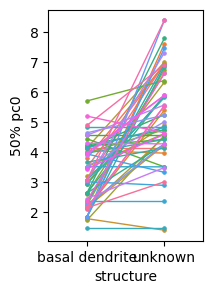

In [305]:
hfig,ax = plt.subplots(1,figsize=(2,3))
sns.pointplot(data=df_melted, x='structure', y='50% pc0', hue='post',linewidth=1,legend=False)

<AxesSubplot:ylabel='ratio pc0 median'>

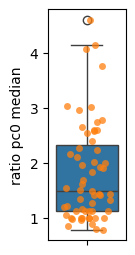

In [306]:
pivot_df.loc[:,'ratio pc0 median'] = pivot_df['unknown'].div(pivot_df['basal dendrite'])

hfig,ax = plt.subplots(1,figsize=(1,3))
sns.boxplot(pivot_df, y="ratio pc0 median",ax=ax)
sns.stripplot(pivot_df, y="ratio pc0 median",jitter=0.3,alpha=0.75,ax=ax)

#### pairplot number inputs onto unknown vs basal dend 

In [ ]:
mask = df_syn['post_type'].isin(['mg2','mg1'])

grouped_df = df_syn[mask][['post','structure','pre']].groupby(['post','structure']).count()
grouped_df = grouped_df.reset_index()

pivot_df = grouped_df.pivot(index='post', columns='structure', values='pre').fillna(0)# 

pivot_df.loc[:,'not_bd'] = pivot_df[['unknown','apical dendrite','axon','multiple']].sum(axis=1)
# pivot_df.head()

<AxesSubplot:xlabel='unknown', ylabel='basal dendrite'>

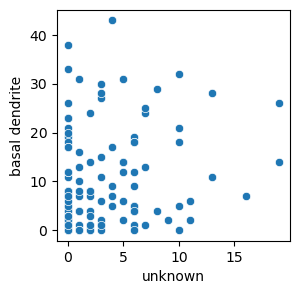

In [260]:
hfig,ax = plt.subplots(1,figsize=(3,3))

sns.scatterplot(data = pivot_df,x='unknown',y='basal dendrite',ax=ax)

In [261]:
pivot_df.corr()

structure,apical dendrite,axon,basal dendrite,multiple,unknown,not_bd
structure,,,,,,
apical dendrite,1.000000,0.377500,0.172486,0.168070,0.568404,0.704138
axon,0.377500,1.000000,0.093451,0.009287,0.305234,0.416123
basal dendrite,0.172486,0.093451,1.000000,0.015106,0.234783,0.228054
multiple,0.168070,0.009287,0.015106,1.000000,0.151329,0.376212
unknown,0.568404,0.305234,0.234783,0.151329,1.000000,0.950837
not_bd,0.704138,0.416123,0.228054,0.376212,0.950837,1.000000


#### for pre mg cells, how does their pc0 correlate with making syn onto basal dendrite or unknown #

In [192]:
mask = df_syn['post_type'].isin(['mg2','mg1'])
merge_on = 'pre'

df_morpho_pca[merge_on] = df_morpho_pca['id'].astype('int') #create a column to sync this data with 'pre' id in each column
merged_df = pd.merge(df_syn[mask], df_morpho_pca[[merge_on,'0']], on=merge_on) # merge df_syn with the pca results on pc0
merged_df.rename({'0':'pre_pc0'},axis=1,inplace=True)

merged_df.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type,pre_pc0
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2,5.044233
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2,5.044233
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2,5.044233
3,6,126618353,213605530,basal dendrite,360.096,313.808,51.39,-54.703583,mg1,mg2,5.044233
4,7,126618353,473631846,basal dendrite,358.688,314.912,51.33,-55.962693,mg1,mg2,5.044233


In [193]:
# for each post cell and each sub-structure, what is the stats of the pre-mg pc0 value:
grouped_df = merged_df.groupby(['pre','structure'])['pre_pc0'].describe().reset_index()
grouped_df.head()

,pre,structure,count,mean,std,min,25%,50%,75%,max
0,40448913,basal dendrite,1.0,6.086114,NaN,6.086114,6.086114,6.086114,6.086114,6.086114
1,40448913,unknown,3.0,6.086114,0.000000e+00,6.086114,6.086114,6.086114,6.086114,6.086114
2,40729265,basal dendrite,1.0,0.946335,NaN,0.946335,0.946335,0.946335,0.946335,0.946335
3,41579854,basal dendrite,16.0,1.748165,6.879800e-16,1.748165,1.748165,1.748165,1.748165,1.748165
4,41579854,multiple,1.0,1.748165,NaN,1.748165,1.748165,1.748165,1.748165,1.748165


<AxesSubplot:xlabel='50%', ylabel='count'>

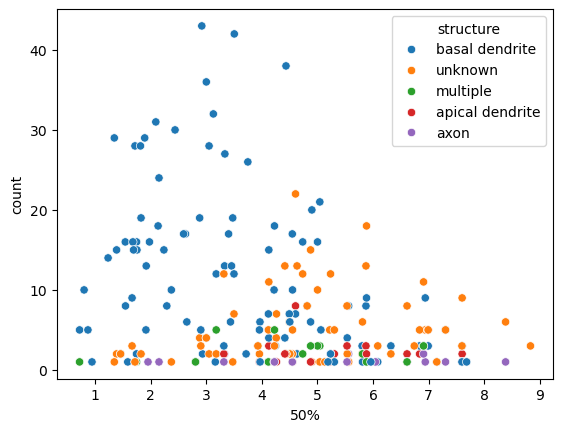

In [197]:
# if an MG cell makes more synapses onto each structure of mg cells, is it more likely to be smaller pc0 or larger?
# mask = grouped_df['structure'].isin(['basal dendrite'])
indep_var = '50%'
sns.scatterplot(data = grouped_df,x=indep_var,y='count',hue='structure')

<AxesSubplot:xlabel='50%', ylabel='count'>

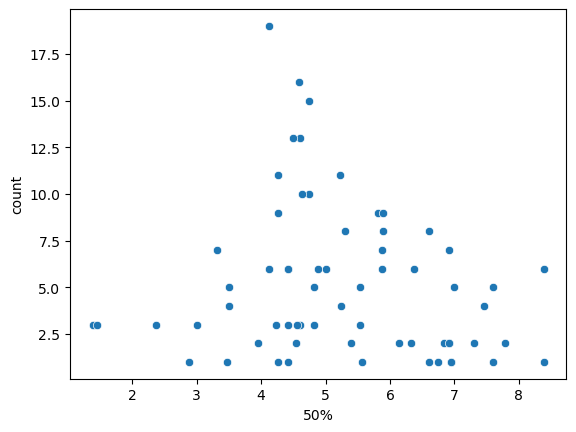

In [296]:
# if an MG cell makes more synapses onto 'unknown' of mg cells, is it more likely to be smaller pc0 or larger?
mask = grouped_df['structure'].isin(['unknown'])
indep_var = '50%'
sns.scatterplot(data = grouped_df[mask],x=indep_var,y='count')

In [291]:
grouped_df[grouped_df['structure'].isin(['unknown'])][['count','50%']].corr()

,count,50%
count,1.000000,-0.156381
50%,-0.156381,1.000000


<AxesSubplot:xlabel='50%', ylabel='count'>

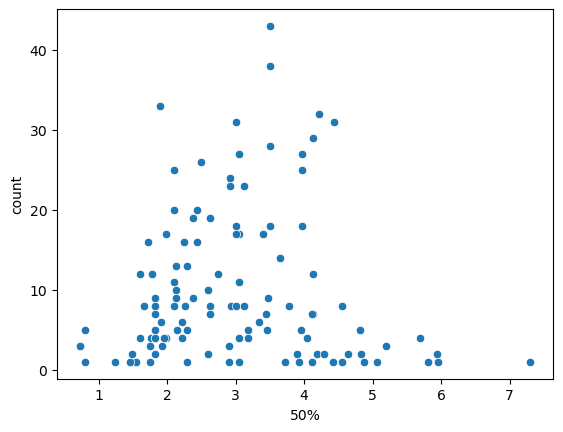

In [295]:
# if an MG cell makes more synapses onto 'unknown' of mg cells, is it more likely to be smaller pc0 or larger?
mask = grouped_df['structure'].isin(['basal dendrite'])
indep_var = '50%'
sns.scatterplot(data = grouped_df[mask],x=indep_var,y='count')

In [292]:
grouped_df[grouped_df['structure'].isin(['basal dendrite'])][['count','50%']].corr()

,count,50%
count,1.000000,-0.000007
50%,-0.000007,1.000000


# Adjacency Matrix

## Graph with individual cells as nodes

allows to search paths through network using all connections in df_edges

Uses df_edges

In [200]:
df_edges

,pre,post,pre_type,post_type,weight
0,300131090,392814322,mg1,lf,29
1,473631846,305332461,mg2,lg,29
2,390294014,652529320,mg2,lg,27
3,559381249,303969144,mg2,lg,24
4,303166992,476044282,mg2,lg,23
...,...,...,...,...,...
1494,385434515,301727988,mg2,lg,1
1495,386117124,472114046,mg2,mg1,1
1496,386224676,394115741,mg1,lf,1
1497,386300356,40508404,mg2,mg1,1


In [37]:
nodes_to_graph = set(df_edges['pre'].unique())|set(df_edges['post'].unique())

G = nx.DiGraph()

# Add nodes with unique IDs and cell_type attribute
for k in nodes_to_graph:
    G.add_node(k, cell_type=df_type[df_type['id'].isin([k])]['cell_type'].values[0])
# Add more nodes as needed

# Add edges between nodes (neurons
for index, row in df_edges.iterrows():
    pre_type = row['pre']
    post_type = row['post']
    weight = row['weight']
    
    G.add_edge(pre_type, post_type, weight=weight)


## adjacency matrix

In [38]:
nlist = []
tlist = ['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']
for t in tlist:
    for i in G.nodes():
        if G.nodes[i]['cell_type']==t:
            nlist.append(i)

In [39]:
nm1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg1']])
nm2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['mg2']])
no1 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lg']])
no2 = len([x for x,y in G.nodes(data=True) if y['cell_type'] in ['lf']])

nt = nm1+nm2+no1+no2

In [40]:
A = nx.to_numpy_array(G,nodelist=nlist,nonedge=np.NaN)

In [41]:
dfA = pd.DataFrame(A)

ctype_col = [df_type[df_type['id'].isin([n])]['cell_type'].values[0] for n in nlist]
dfA['cell_type']=ctype_col

mask = (dfA.drop(columns=['cell_type']).sum(axis=1)>1)

In [42]:
dfA=dfA[mask]

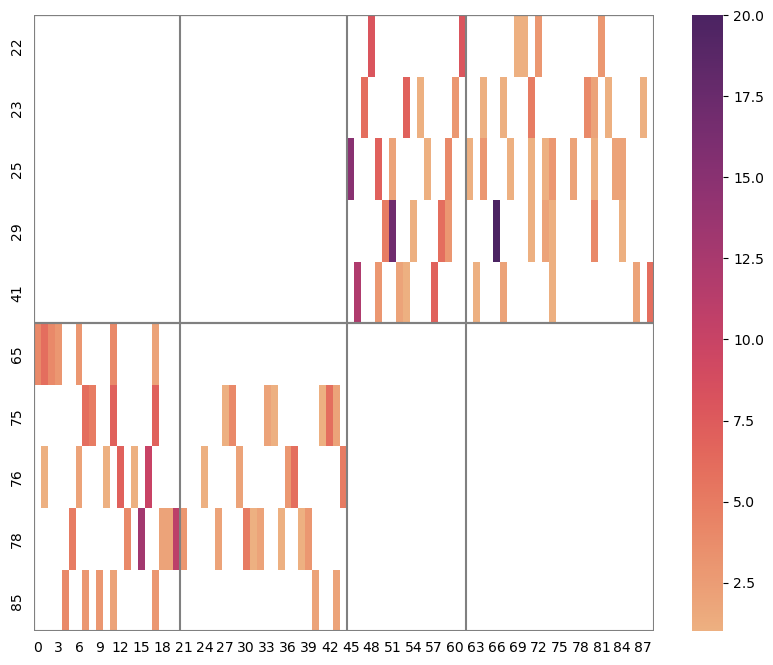

In [45]:
hfig,ax = plt.subplots(1,figsize=(10,8))
sns.heatmap(data=dfA.drop(columns=['cell_type']),ax=ax,cmap='flare') #'flare_r'

n_hlines =  [0,sum(dfA['cell_type']=='lg'),sum(dfA['cell_type']=='mg1'),
            sum(dfA['cell_type']=='lf'),sum(dfA['cell_type']=='mg2'),len(dfA)]
# [0,sum(dfA['cell_type']=='lg'),sum(dfA['cell_type']=='mg1'),sum(dfA['cell_type']=='sg1'),
#              sum(dfA['cell_type']=='lf'),sum(dfA['cell_type']=='mg2'),sum(dfA['cell_type']=='sg2'),len(dfA)]

nacc = 0
for nh in n_hlines:
    ax.hlines([nacc],0,nt,color='gray')
    nacc+=nh

n_vlines = [0,no1,nm1,no2,nm2,nt]#,ng,ns1,ns2,ntsd,ngd,ngs,nt]
nacc = 0
for nv in n_vlines:
    ax.vlines([nacc],0,nm1+nm2,color='gray')
    nacc+=nv

ax.tick_params(left=False, bottom=False)
# ax.set(xticklabels=[],yticklabels=[]);

plt.savefig('/Users/kperks/Downloads/adjacency-mg-post_mg-out.svg',transparent=True) 

# Connection patterns

In [36]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf','smpl','grc','aff']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['mg1','mg2'] #should be all that is in df_pfsyn anyway
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
            index='pre', columns='post_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['pre_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('pre')
df_map = df_map.drop(['pre_type'],axis=1)

In [37]:
df_map.head()

post_type,grc,lf,lg,mg1,mg2,sg1,sg2,smpl
pre,,,,,,,,
41579854,1.0,29.0,0.0,0.0,17.0,0.0,0.0,1.0
41610656,0.0,23.0,0.0,0.0,0.0,0.0,1.0,0.0
41843700,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0
42201085,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
42632020,0.0,32.0,0.0,0.0,29.0,0.0,1.0,1.0


## connectivity heatmap

[]

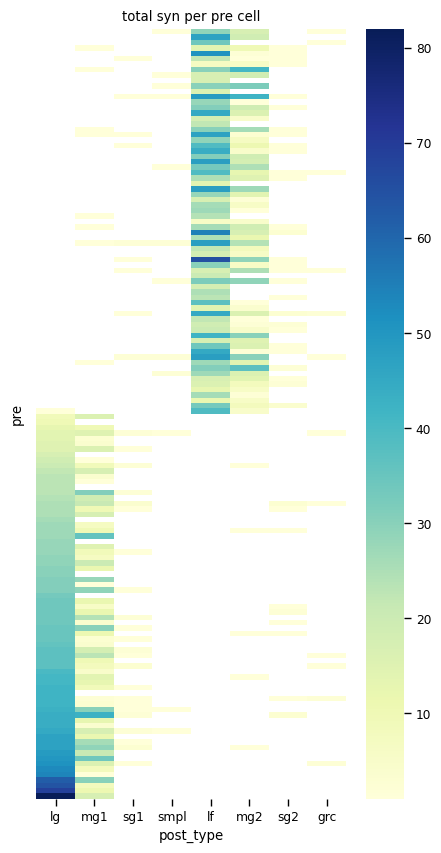

In [44]:
target_order = ['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range


# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')




# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])



In [45]:
lg_map = df_map[df_map['lg']>1].sort_values(['lg'])

In [46]:
lf_map = df_map[~df_map.index.isin(lg_map.index)].sort_values(['lf'],ascending=False)

In [47]:
sorted_full = pd.concat([lf_map,lg_map])

[]

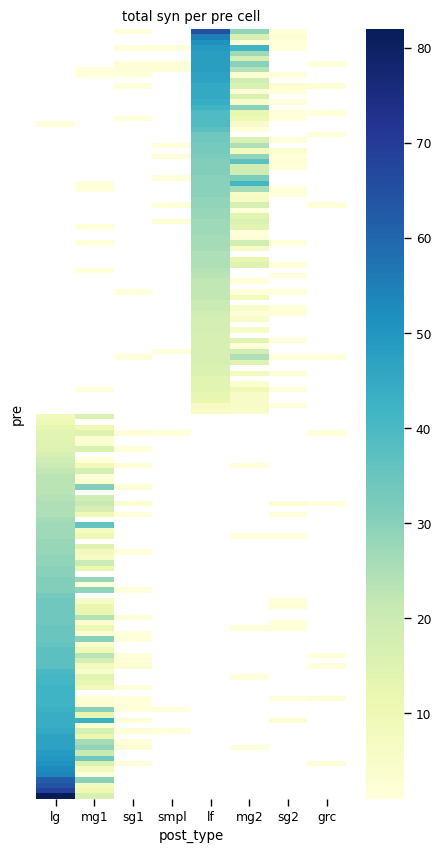

In [42]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

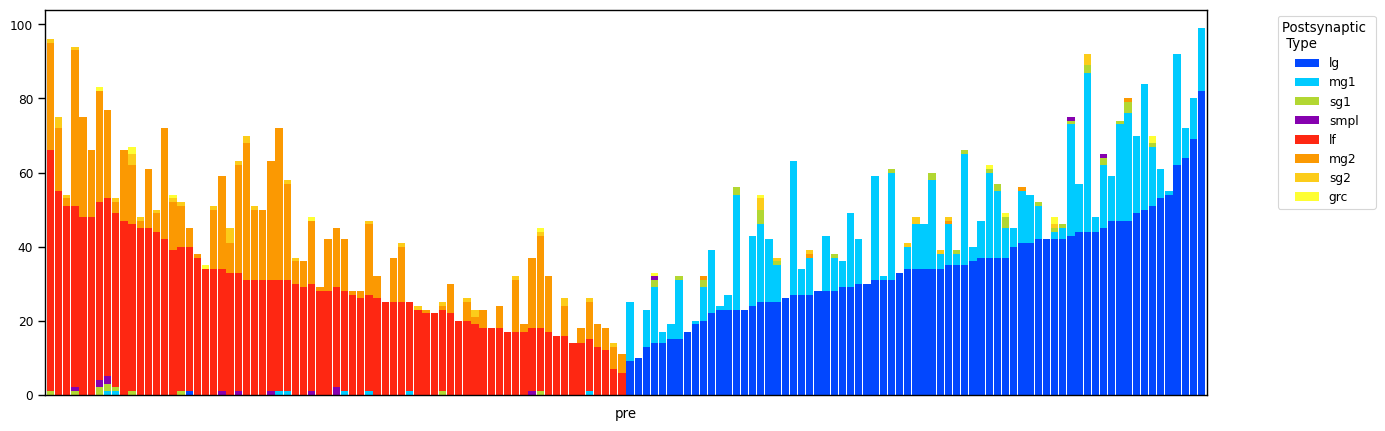

In [48]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_ALL_stacked_bar.svg', format='svg', transparent=True)

In [168]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100)#.round(0)

In [174]:
lg_map = df_norm[df_norm['lg']>5].sort_values(['lg'])

lf_map = df_norm[~df_norm.index.isin(lg_map.index)].sort_values(['lf'],ascending=False)

norm_sorted_full = pd.concat([lf_map,lg_map])

[]

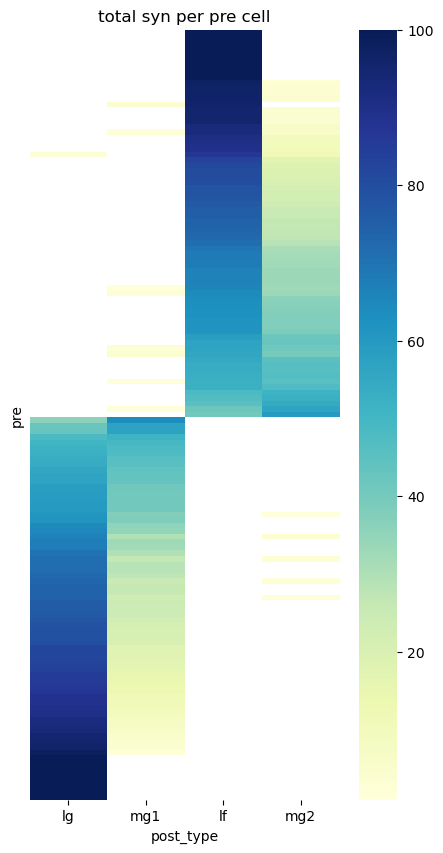

In [175]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=norm_sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

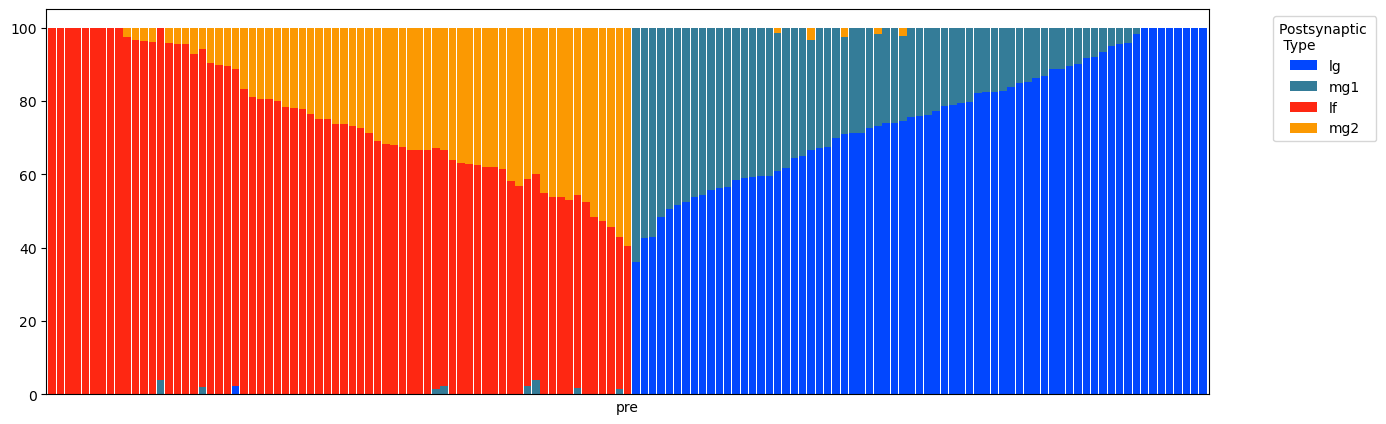

In [177]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
norm_sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_stacked_bar_normalized.svg', format='svg', transparent=True)

# KC fig 4 analysis

In [236]:
def get_p_connect(df_edges,mask,count_type):

# count_type = 'nsyn' # 'ncells' #
# mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

    types_ = ['mg1','mg2']# 
    df_map = pd.DataFrame()
    for t in types_:
        if count_type == 'nsyn':
            df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
                ['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
                index='pre', columns='post_type', values='weight').fillna(0).reset_index()
        
        if count_type == 'ncells':
            df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
                ['pre','pre_type','post_type']).count().reset_index().pivot(
                index='pre', columns='post_type', values='post').fillna(0).reset_index()
        
        df_grouped['pre_type']=t
        df_map = pd.concat([df_map,df_grouped])
        
    df_map = df_map.fillna(0)
    df_map = df_map.set_index('pre')
    df_map = df_map.drop(['pre_type'],axis=1)
    
    
    df_norm = df_map.div(df_map.sum(axis=1),axis=0)#.mul(100).round(0)

    return df_norm
# sns.heatmap(data=df_norm.sort_values('lcf'), annot=True, fmt="0.0f", cmap="YlGnBu")

## data

In [231]:
df_syn['pre'].nunique()

139

In [232]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2,"(-55, -50]"
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2,"(-55, -50]"
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2,"(-55, -50]"
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf,"(-55, -50]"
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf,"(-60, -55]"


## connection probability by cell type

In [254]:
count_type = 'nsyn'
included_groups = ['lg','mg1','lf','mg2']
by_group='lf'

### data

In [255]:
# df_edges=df_syn.drop(['Unnamed: 0','x','y','z','y_adj','structure','depth'],axis=1).value_counts().reset_index(name='weight')

mask = (df_edges['post_type'].isin(included_groups))

df_norm_data = get_p_connect(df_edges,mask,count_type)

result_data = df_norm_data[(df_norm_data[by_group] != 0)].mean()

### shuffle result

In [256]:
result_df = pd.DataFrame()

df_syn_rand = deepcopy(df_syn)

# Iterate the specified number of times
for i in range(100):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_rand.drop(['Unnamed: 0','x','y','z','y_adj','structure','depth'],axis=1).value_counts().reset_index(name='weight')
    mask = (df_edges_shuff['post_type'].isin(included_groups))

    df_norm = get_p_connect(df_edges_shuff,mask,count_type)
    
    # Compute the mean for rows where 'mg2' is not zero
    mean_row = df_norm[(df_norm[by_group] != 0)].mean(numeric_only=True) #df_shuffled[df_shuffled[by_group] != 0].mean(numeric_only=True)
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame([mean_row])], ignore_index=True)

### plot comparison

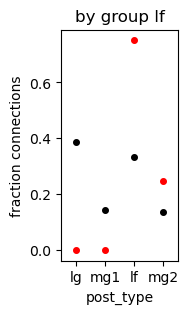

In [257]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 3,order = included_groups,errorbar=('ci'))
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 3,order = included_groups)

ax.set_ylabel('fraction connections')
ax.set_title(f'by group {by_group}')

plt.savefig(f'/Users/kperks/Downloads/mg_output_conditionalP_{by_group}.svg', format='svg', transparent=True)

# conditional OUTPUT analysis

In [115]:
def get_conditional_output(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
    
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 0.05)].mean().values))

    if normalize==False:
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 1)].mean().values))

    order = df_map.columns
        
    return result,order

In [78]:
pre_groups = ['mg1','mg2']
post_groups = ['mg1','mg2','lg','lf']

### shuffle result

In [81]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['post','x','y','z','y_adj','post_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['post']] = shuff_rows['post'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['post_type']] = shuff_rows['post_type'].values

    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

    result_ = np.asarray(get_conditional_output(df_edges_shuff,normalize=True))
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

In [88]:
df_edges_shuff.head()

,pre,post,pre_type,post_type,depth,weight
0,40729265,302637877,mg2,lg,"(-20, -15]",3
1,646634295,301727988,mg2,lg,"(-25, -20]",3
2,40448913,393325331,mg2,lf,"(-10, -5]",3
3,473631846,215526370,mg2,lg,"(-30, -25]",3
4,127870654,392072123,mg1,lf,"(-50, -45]",3


In [87]:
u_mat

array([[0.33081537, 0.38921647, 0.14469992, 0.13526824],
       [0.33071996, 0.38933321, 0.14469263, 0.13525419],
       [0.32827421, 0.38682434, 0.15062883, 0.13427262],
       [0.32807375, 0.38616431, 0.14351961, 0.14224233]])

### data

In [116]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(pre_groups) & df_syn_data['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')


result_data,order = get_conditional_output(df_edges_data,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

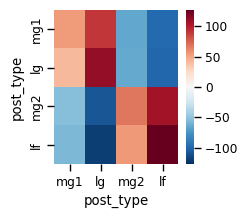

In [120]:

# Define the desired order
order = ['mg1','lg','mg2','lf']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

plt.savefig('/Users/kperks/Downloads/mg_output_conditional_output_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='pre_type', ylabel='pre_type'>

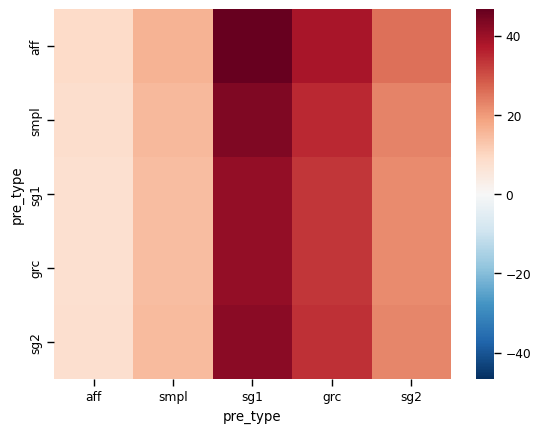

In [408]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

result_ = np.asarray(get_conditional_input(df_edges_shuff))

cond_input_mat = pd.DataFrame(result_,columns = df_map.columns, index = df_map.columns)

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# Patterns of connectivity (PCA)

In [46]:
def calculate_percent_total(row):
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## params of analysis

In [47]:
# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'

# Desired pre_types and order
source_types_order = ['mg1','mg2']#['pf']#
# Desired post_types order
target_types_order =  ['mg1','lg', 'mg2','lf'] #['aff',  'sg1','mg1', 'grc', 'sg2','mg2']

## data

In [48]:
# df_edges=df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the function to each row
# norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca = PCA(n_components=npc)  # You can change the number of components as needed

pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

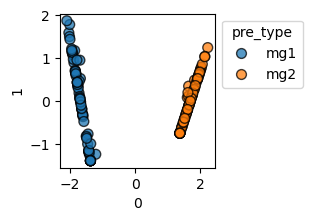

In [53]:
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=50,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

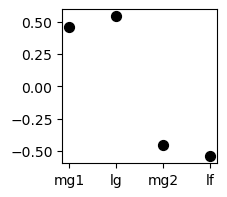

In [51]:
hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(['mg1','lg','mg2','lf'],[l[0] for l in loadings],color = 'black',s=50)

In [54]:
result_data = pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca.explained_variance_ratio_)))

### shuffle result

In [55]:
result_df = pd.DataFrame()

df_syn_rand = deepcopy(df_syn)

# Iterate the specified number of times
for i in range(50):
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values
    
    df_edges_shuff=df_syn_rand.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    # Filter out rows with post_type not in post_types_order
    df_edges_filtered = df_edges_shuff[df_edges_shuff[dsource].isin(source_types_order)]
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the function to each row
    # norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
    norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca = PCA(n_components=npc)  # You can change the number of components as needed
    pca_result = pca.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

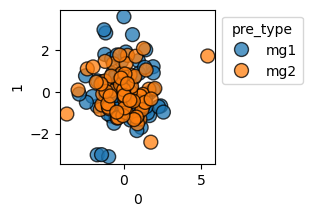

In [56]:
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

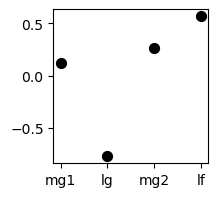

In [57]:
hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(['mg1','lg','mg2','lf'],[l[0] for l in loadings],color = 'black',s=50)

### plot comparison

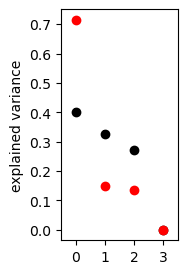

In [273]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig(f'/Users/kperks/Downloads/mg_output_pca.svg', format='svg', transparent=True)

# divergence and convergence

## post synaptic

In [274]:
desired_combinations = [
    ('mg1', 'mg2'),
    ('mg1', 'lf'),
    ('mg2', 'mg1'),
    ('mg2', 'lg')
]
# filtered_df = df_edges[df_edges[['pre_type', 'post_type']].apply(tuple, axis=1).isin(desired_combinations)]


In [276]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
divergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'pre', 'divergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # Group by pre and count unique post cells for each pre cell
    subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['post'].nunique().reset_index()
    subset_divergence_counts.rename(columns={'post': 'divergence_count'}, inplace=True)

    # # Group by pre and count synapse total for each pre cell
    # subset_divergence_counts = subset_df.groupby(['pre_type', 'pre'])['weight'].sum().reset_index()
    # subset_divergence_counts.rename(columns={'weight': 'divergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_divergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    divergence_counts = pd.concat([divergence_counts, subset_divergence_counts])

# Display the resulting DataFrame
divergence_counts.head()
divergence_counts[divergence_counts['divergence_count'] != 0]

,pre_type,post_type,pre,divergence_count
0,mg1,mg2,41579854,10
1,mg1,mg2,42632020,6
2,mg1,mg2,44548558,2
3,mg1,mg2,126618353,9
4,mg1,mg2,127870654,11
...,...,...,...,...
64,mg2,lg,642458763,6
65,mg2,lg,644823522,5
66,mg2,lg,644824766,6
67,mg2,lg,646634295,6


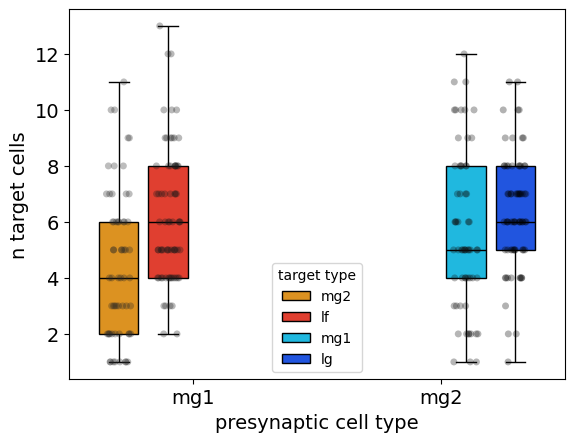

In [281]:

ax = sns.boxplot(data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',palette=syn_colors,dodge=True,gap=0.2)#,k_depth='full')
sns.stripplot(ax = ax, data=divergence_counts,x = 'pre_type',y='divergence_count',hue='post_type',dodge=True,jitter=0.2,alpha=0.3,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('target type')

# ax.set_ylabel('number of target cells')
ax.set_ylabel('n target cells')
ax.set_xlabel('presynaptic cell type')

plt.savefig('/Users/kperks/Downloads/divergence_count.svg') 

In [288]:
# list(filtered_df.groupby(['pre_type','pre']))

# Initialize an empty DataFrame to store the results
convergence_counts = pd.DataFrame(columns=['pre_type', 'post_type', 'post', 'convergence_count'])

# Iterate over each desired combination
for pre_type, post_type in desired_combinations:
    # Filter the DataFrame for the current combination
    subset_df = df_edges[(df_edges['pre_type'] == pre_type) & (df_edges['post_type'] == post_type)]
    
    # # Group by pre and count unique post cells for each pre cell
    # subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['pre'].nunique().reset_index()
    # subset_convergence_counts.rename(columns={'pre': 'convergence_count'}, inplace=True)

    # Group by pre and count synapse total for each pre cell
    subset_convergence_counts = subset_df.groupby(['pre_type', 'post'])['weight'].sum().reset_index()
    subset_convergence_counts.rename(columns={'weight': 'convergence_count'}, inplace=True)
    
    # Add pre_type and post_type columns
    subset_convergence_counts['post_type'] = post_type
    
    # Append the subset DataFrame to the results DataFrame
    convergence_counts = pd.concat([convergence_counts, subset_convergence_counts])

# Display the resulting DataFrame
convergence_counts.head()
convergence_counts[convergence_counts['convergence_count'] != 0]

,pre_type,post_type,post,convergence_count
0,mg1,mg2,40448913,5
1,mg1,mg2,40665046,3
2,mg1,mg2,41825714,7
3,mg1,mg2,42769344,10
4,mg1,mg2,45727047,7
...,...,...,...,...
37,mg2,lg,645210795,15
38,mg2,lg,647112371,41
39,mg2,lg,647640784,24
40,mg2,lg,650161520,53


In [289]:
convergence_counts[(convergence_counts['pre_type'].isin(['mg1','mg2'])) & (convergence_counts['post_type'].isin(['lg','lf']))].sort_values('convergence_count')

,pre_type,post_type,post,convergence_count
10,mg2,lg,131737545,1
35,mg1,lf,486906861,4
34,mg1,lf,485096532,5
43,mg1,lf,651694253,6
33,mg1,lf,484089475,7
...,...,...,...,...
23,mg2,lg,305332461,112
24,mg1,lf,393325331,120
12,mg2,lg,214503199,127
28,mg2,lg,476044282,135


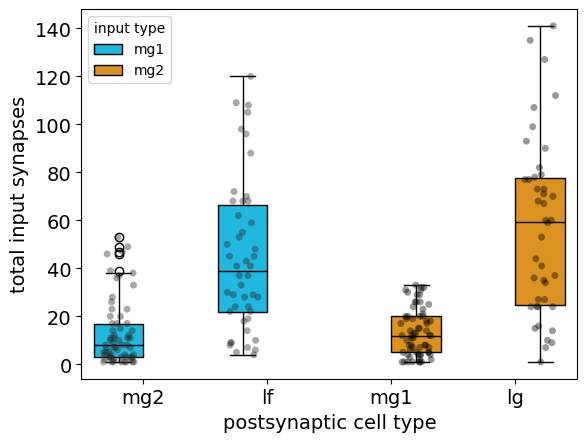

In [290]:

ax = sns.boxplot(data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',palette=syn_colors,dodge=0.5)
sns.stripplot(ax = ax, data=convergence_counts,x = 'post_type',y='convergence_count',hue='pre_type',dodge=True,jitter=0.25,alpha=0.4,legend=False,palette='dark:black')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)

leg = ax.axes.get_legend()
leg.set_title('input type')

# ax.set_ylabel('number of input cells')
ax.set_ylabel('total input synapses')
ax.set_xlabel('postsynaptic cell type')

plt.savefig('/Users/kperks/Downloads/convergence_weight.svg') 

# OTHER

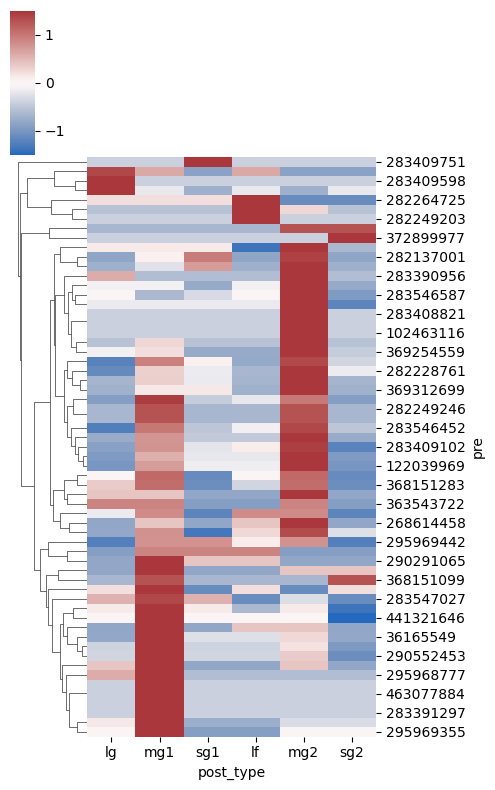

In [180]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<Axes: xlabel='lf', ylabel='mg1'>

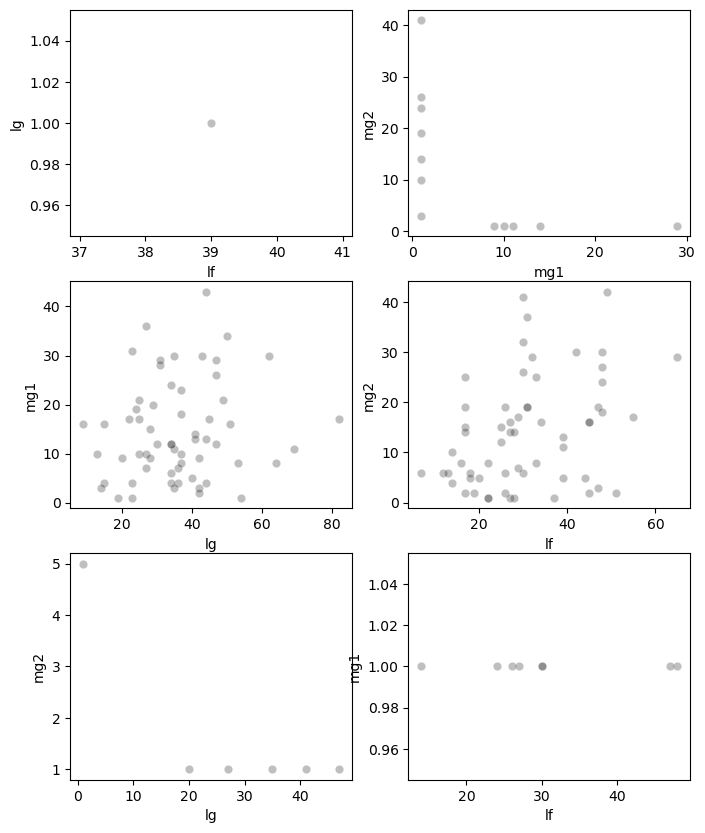

In [163]:
hfig,ax = plt.subplots(3,2,figsize=(8,10))
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)], x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['mg1'] != 0)& (df_map['mg2'] != 0)], x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg1'] != 0)], x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg2'] != 0)], x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg2'] != 0)], x = 'lg', y = 'mg2', ax = ax[2][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg1'] != 0)], x = 'lf', y = 'mg1', ax = ax[2][1],alpha = 0.25,color = 'black')